In [1]:
from math import exp, pi

import matplotlib.pyplot as plt
from numpy import concat
from numpy import array, linspace, matmul, ndarray
from numpy.linalg import inv, det
from numpy.random import Generator, PCG64

from hmmadn import HMMGen, SemiGen, SemiViterbi, Viterbi
from hmmadn.utils import DurationProbVec, ObservationLaw, ProbVec, get_duration_error, get_error

## Modèles de Markov caché (HMM)

Nous définissons un modèle de markov caché avec les éléments suivants :

1. Le temps est discrèt.
2. A chaque temps $t$, le système est dans un état caché.
3. $S$ est l'ensemble d'états cachés, $S=\{0, \cdots, K \}$. Pour décrire l'état au temps $t$, nous écrivons $S_t=s$ où $s\in S$. $N$ est la cardinalité de $S$. 
4. Nous écrivons la séquence d'états jusqu'au temps $t$ comme $S(t)$.
5. A chaque temps $t+1$, l'état actuel transitionne à un nouvel état selon les probabilités de transition, tout en respectant la propriété de Markov : 

$$P(S_{t+1}=s | S_0=q,\cdots,S_{t}=r)=P(S_{t+1}=s|S_{t}=r)$$


6. La matrice de transition des états cachés est définie par 
$A=\{a_{ij}\}$
où
$a_{ij}=P(S_t=s|S_{t-1}=d)$ avec $s,d\in S$

7. A chaque temps $t$, l'état actuel génère une observation selon les probabilités d'observation. Pour décrire l'observation au temps $t$, nous écrivons $O_t=o$ où $o\in O$ et $O$ est l'ensemble des valeurs possibles des observations.

8. La séquence des observations jusqu'au temps $t$ est écrite comme $O(t)$.

9. Les probabilités d'observation sont définies selon les cas discrét ou continu :
    * **discrèt :** $O$ est un ensemble discrète et fini. La cardinalité est donné par $M$. Nous définissions une matrice de probabilité de taille $N\times M$ par $B=\{b_s(o)\}$ où $b_s(o)=P(O_t=o|S=s)$
    * **continu :** $O$ est normalement l'ensemble de nombres réelles, $R$. Pour chaque état, nous choisissons une densité de probabilité valide, $f_s(o)$, et écrivons 
    $P(O_t=o|S=s)=f_s(o)$

4. Nous initialisons le premier état du modèle en définissant $\mu_s=P(S_1=s)$ pour chaque $s\in S$. $\mu$ définit la loi d'initialisation telle que $\sum_{s\in S}\mu_s=1$, et selon laquelle nous pouvons tirer un état initial.

### Génération de données

Nous pouvons générer une séquence d'états selon les étapes suivantes :

1. Tirer un état initial selon la loi $\mu$ et définir $S_t=s$, où $t=1$ et $s\in S$.
2. Générer une observation selon la probabilité d'observation et l'état actuel. Définir $O_t=o$ où $o\in O$ est l'observation générée.
3. Tirer le prochain état selon la matrice de transition. Définir $S_{t+1}=r$, où $r\in S$ est l'état tiré.
4. Répéter les étapes 2 et 3 jusqu'à $t=T$.

### L'Algorithme de Viterbi

L'Algorithme de Viterbi nous permet d'estimer la séquence d'états qui a généré les observations. Pour ce faire, nous suppons que les paramètres du modèle ainsi que la séquence d'observations sont connus.

Tout d'abord, nous définissons quelques termes utilisés dans l'algorithme.

$\delta_t(s)$ représente la probabilité maximale d'avoir parcouru la séquence d'états $S(t)$, observé la séquence $O(t)$, et atteindre $S_t=s$.
$$\delta_t(s)=\max_{S(t-1)} P(S(t-1),S_t=s, O(t))$$

Une définition itérative peut être montrée :

$$\delta_t(s)=\max_{r\in S}[a_{rs}\delta_{t-1}(r)]b_{s}(O_t)$$

Ici, $\delta_{t-1}(r)$ représente, donné toutes les observations jusqu'au temps $t-1$, la probabilité d'avoir parcouru tous les états précédents et achevé en état $r$ au temps $t$. Ainsi, nous multiplions cette probabilité par $a_{rs}$ pour calculer la probabilité d'atteindre l'état $s$ au temps $t$. Pusique nous cherchons la probabilité maximale, nous prenons l'état $r\in S$ qui maximise cette valeur. Enfin, nous multiplions par $b_{s}(O_t)$, (ou $f_{s}(O_t)$ dans le cas continu) pour prendre en compte la probabilité d'avoir observé $O_t$ le temps que nous sommes dans l'état $s$.

Nous pouvons initialiser les $\delta_t(s)$ en calculant : 

$$\delta_1(s)=\mu_s b_{s}(O_t)$$

Notons qu'au chaque temps $t$, nous calculons $\delta_{t}(s)$ pour chaque $s\in S$. Afin de détéminer quel état s'est avéré, nous traversons les deltas en arrière depuis temps $T$ en considérant l'état précédent le plus probable qui nous mène à l'état actuel.

Donc, nous définissons : 

$$\phi_t(s)=\argmax_{r\in S}[a_{rs}\delta_{t-1}(r)]$$

Cela représente l'état le plus probable au temps $t-1$ qui nous a mené à l'état $s$ au temps $t$. Pour chaque temps $t$, nous calculons $\phi_t(s)$ pour chaque $s\in S$. Nous utilisons l'état au temps $t+1$ pour déterminer l'état optimal au temps $t$. Pour initialiser la traversée au temps $T$, nous définissons l'état optimal comme

$$S^*_T=\argmax_{s\in S}\delta_T(s)$$

Algorithime :
1. $t=1$, pour $s\in S$

$$\delta_1(s)=\mu_s b_s(O_1)$$
$$\phi_1(s)=0$$

2. Pour $t=2:T$, pour $s\in S$
    $$\delta_t(s)=\max_{r\in S}[a_{rs}\delta_{t-1}(r)]b_{s}(O_t)$$
    $$\phi_t(s)=\argmax_{r\in S}[a_{rs}\delta_{t-1}(r)]$$

3. Définir
$$S^*_T=\argmax_{s\in S}\delta_T(s)$$

4. Pour $t=T-1:(-1):1$
$$S^*_t=\argmax_{s\in S}\delta_{t+1}(S^*_{t+1})$$




### HMM avec des observations selon une loi gaussienne

In [2]:
def multivariate_normal_pdf(x, mean, cov_matrix):
    return (
        ((2 * pi) ** (-x.size / 2))
        * (det(cov_matrix) ** -0.5)
        * exp(
            -0.5 * matmul(
                (x - mean).T,
                matmul(inv(cov_matrix), (x - mean))
            )
        ))

class GaussObsLaw(ObservationLaw):
    """Cette classe gère la génération des observations selon les états donnés."""

    def __init__(self, state_parameters: dict) -> None:
        self.gen = Generator(PCG64())
        self.state_parameters = state_parameters

    def gen_obs(self, state: str) -> any:
        return self.gen.multivariate_normal(
            self.state_parameters[state]['mean'],
            self.state_parameters[state]['cov'],
        )
    
    def b_Sj_Ot(self, state: int, obs: ndarray) -> float:
        return multivariate_normal_pdf(
            obs,
            self.state_parameters[state]['mean'],
            self.state_parameters[state]['cov'],
        )
    
    def b_Sj_Ot_list(self, state: int, obs: list[ndarray]) -> float:
        return array([
            self.b_Sj_Ot(state, o) for o in obs
        ]).prod()
    
    def __call__(self, state: any) -> any:
        return self.gen_obs(state)


def get_state_params(alpha: float = 1.0, beta: float = 1.0) -> dict:
    """Fonction pour paramétriser la variance de notre modèle."""
    return {
        0: {
            'mean': array([2, 1]),
            'cov': alpha * array(
                [[1, 0],
                [0, 1]]
            ),
        },
        1: {
            'mean': array([-1, 2]),
            'cov': beta * array(
                [[0.5, 0],
                [0, 0.5]]
            ),
        }
    }



Dans notre exemple, nous définissons le modèle suivant : 

1. Il y a deux états : $S=\{0, 1\}$
2. La matrice de transition est donnée par : 
$$ A = \begin{bmatrix} 0.6 & 0.4 \\ 0.8 & 0.2 \\ \end{bmatrix} $$
3. Le loi d'initialisation est donnée par :
$$\mu = \{0.5 \enspace 0.5\}$$
2. $f_s(O_t)$ est une distribution gaussienne, où nous précisons la moyenne et la variance pour chaque état : 
$$\text{moyenne d'état 0 : }  \begin{bmatrix} 2 \\ 1 \end{bmatrix} \text{ variance d'état 0 : }  \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ \end{bmatrix}$$
$$\text{moyenne d'état 1 : }  \begin{bmatrix} -1 \\ 2 \end{bmatrix} \text{ variance d'état 1 : }  \begin{bmatrix} 0.5 & 0 \\ 0 & 0.5 \\ \end{bmatrix}$$

In [3]:
T = 1000
N = 2

states = range(N)
trans_mat = array([
    [0.6, 0.4],
    [0.8, 0.2]
])
state_params = get_state_params()
obs_law = GaussObsLaw(state_params)

hmm_gen = HMMGen(
    states, trans_mat, obs_law
)
observations, states_obs = hmm_gen.gen_obs(T, states=True)

La sortie de la génération des données est une liste des observations ainsi qu'une liste des états corréspondants. Nous passons la liste des observations à l'algorithme de Viterbi. Nous utilisons les observations pour calculer l'erreur de Viterbi.

In [4]:
# Vérification des moyennes des valeurs générées

one_count = 0
zero_count = 0
one_obs = []
zero_obs = []
zipped_obs_list = zip(observations, states_obs)
for obs in zipped_obs_list:
    if obs[-1] == 0:
        zero_count += 1
        zero_obs.append(obs[0])
    else:
        one_count += 1
        one_obs.append(obs[0])

print("Moyenne empirique de l'état 0", sum(zero_obs) / zero_count)
print("Moyenne théorique de l'état 0", state_params[0]['mean'])

print("Moyenne empirique de l'état 1", sum(one_obs) / one_count)
print("Moyenne théorique de l'état 1", state_params[1]['mean'])

Moyenne empirique de l'état 0 [1.93781362 0.98872478]
Moyenne théorique de l'état 0 [2 1]
Moyenne empirique de l'état 1 [-1.02720261  1.9595129 ]
Moyenne théorique de l'état 1 [-1  2]


In [5]:
viterbi = Viterbi(
    states=states,
    obs_list=observations,
    trans_mat=trans_mat,
    mus=hmm_gen.mus,
    b_Sj_Ot_function=obs_law.b_Sj_Ot,
)

viterbi_states = viterbi.run_viterbi()

La sortie de l'algorithme de Viterbi est une liste des états optimaux. Nous passons celle-ci, avec les états observés, afin de calculer l'erreur.

In [6]:
error = get_error(states_obs, viterbi_states, T)

print(f"L'erreur de Viterbi est : {round(error * 100, 2)}%")

L'erreur de Viterbi est : 3.2%


In [7]:
def run_hmm_gen_and_viterbi(state_params) -> float:
    obs_law = GaussObsLaw(state_params)
    hmm_gen = HMMGen(
        states, trans_mat, obs_law
    )
    observations, states_obs = hmm_gen.gen_obs(T, states=True)

    viterbi = Viterbi(
        states=states,
        obs_list=observations,
        trans_mat=trans_mat,
        mus=hmm_gen.mus,
        b_Sj_Ot_function=obs_law.b_Sj_Ot,
    )

    viterbi_states = viterbi.run_viterbi()
    return get_error(states_obs, viterbi_states, T)

runs = 10
cov_steps = linspace(0.05, 1, 20)

alpha_errors = []
for step in cov_steps:
    runs_avg = []
    for _ in range(runs):
        runs_avg.append(run_hmm_gen_and_viterbi(get_state_params(step, 1)))
    alpha_errors.append(
        array(runs_avg).mean()
    )

beta_errors = []
for step in cov_steps:
    runs_avg = []
    for _ in range(runs):
        runs_avg.append(run_hmm_gen_and_viterbi(get_state_params(1, step)))
    beta_errors.append(
        array(runs_avg).mean()
    )




: 

Ici, nous éxecutons la génération des données et l'algorithme de Viterbi plusieurs fois en changeant la variance de chaque état. 

Dans le cas d'alpha, nous modifions la variance de l'état 0 en multipliant la matrice de variance par un scalaire. Nous choisissons les valeurs de 0,05 jusqu'au 1 en pas de 0,05, ce qui est effectivement un pourcentage de la variance d'origine. Nous ne changeons pas la variance de l'état 1. 

Dans le cas de beta, nous utilisons la même approche, mais en échangeant les rôles d'alpha et de beta. 

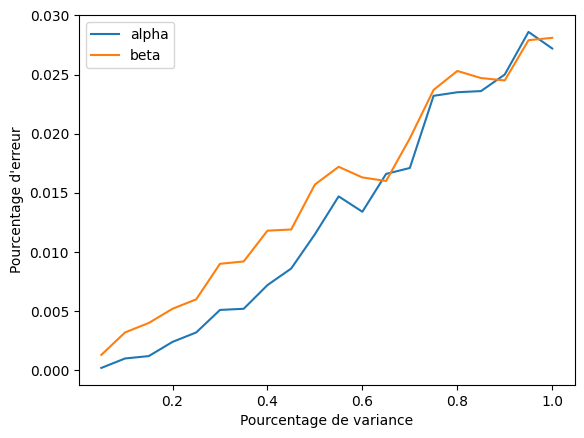

In [8]:
plt.plot(cov_steps, alpha_errors, label='alpha')
plt.plot(cov_steps, beta_errors, label='beta')
plt.ylabel("Pourcentage d'erreur")
plt.xlabel("Pourcentage de variance")
plt.legend()

### HMM avec des observations selon une loi discrète

In [7]:
class DiscreteObsLaw(ObservationLaw):

    def __init__(self, obs_prob_mat: ndarray) -> None:
        self.obs_prob_mat = obs_prob_mat
        self._set_prob_vectors()

    def _set_prob_vectors(self) -> None:
        self.prob_vectors = {
            i: ProbVec(self.obs_prob_mat[i], range(self.obs_prob_mat.shape[1]))
            for i in range(self.obs_prob_mat.shape[0])
        }

    def gen_obs(self, state: int) -> int:
        return self.prob_vectors[state].gen_value()
    
    def b_Sj_Ot(self, state: int, observation: int) -> float:
        return self.obs_prob_mat[state][observation]
    
    def b_Sj_Ot_list(self, state: int, obs: list[int]) -> float:
        return array([
            self.b_Sj_Ot(state, o) for o in obs
        ]).prod()



Dans notre exemple discrèt, nous utilisons presque tous les mêmes paramètres, sauf les probabilités d'observation. Pour cela, nous précisons l'ensemble d'observations possibles et une matrice de probabilités : 
$$O = \{0, 1\}$$
$$B=\begin{bmatrix} 0.9 & 0.1 \\ 0.1 & 0.9 \\ \end{bmatrix} $$

Ensuite, nous pouvons calculer les valeurs moyennes de chaque état : 

$$\begin{align*}
E_{S=0}[O]&=\sum_{o\in O}o b_0(o)\\
&=0\times 0.9+1\times 0,1\\
&=0,1\\
\end{align*}$$

$$\begin{align*}
E_{S=1}[O]&=\sum_{o\in O}o b_1(o)\\
&=0\times 0.1+1\times 0.9\\
&=0.9\\
\end{align*}$$

In [8]:
T = 1000
N = 2

dis_obs_mat = array(
    [[0.9, 0.1],
     [0.1, 0.9]]
)
discrete_obs_law = DiscreteObsLaw(dis_obs_mat)

states = range(N)
trans_mat = array([
    [0.6, 0.4],
    [0.8, 0.2]
])

hmm_gen = HMMGen(
    states, trans_mat, discrete_obs_law
)

observations, states_obs = hmm_gen.gen_obs(T, states=True)

In [9]:
# Vérification des moyennes des valeurs générées

one_count = 0
zero_count = 0
one_obs = []
zero_obs = []
zipped_obs_list = zip(observations, states_obs)
for obs in zipped_obs_list:
    if obs[-1] == 0:
        zero_count += 1
        zero_obs.append(obs[0])
    else:
        one_count += 1
        one_obs.append(obs[0])

print("Moyenne empirique de l'état 0", sum(zero_obs) / zero_count)
print("Moyenne théorique de l'état 0", 0.1)

print("Moyenne empirique de l'état 1", sum(one_obs) / one_count)
print("Moyenne théorique de l'état 1", 0.9)

Moyenne empirique de l'état 0 0.09292035398230089
Moyenne théorique de l'état 0 0.1
Moyenne empirique de l'état 1 0.9161490683229814
Moyenne théorique de l'état 1 0.9


In [10]:
viterbi = Viterbi(
    states=states,
    obs_list=observations,
    trans_mat=trans_mat,
    mus=hmm_gen.mus,
    b_Sj_Ot_function=discrete_obs_law.b_Sj_Ot,
)
viterbi_states = viterbi.run_viterbi()


error = get_error(states_obs, viterbi_states, T)

print(f"L'erreur de Viterbi est : {round(error * 100, 2)}%")

L'erreur de Viterbi est : 9.0%


## Modèles de semi Markov cachés (Semi HMM)

Les modèles de semi Markov cachés (semi HMM) sont une extension des HMMs où nous notons explicitement la durée dans laquelle le système passe dans un état. La durée est elle-même une variable aléatoire. 

Il y a plusieurs suppositions que nous pouvons faire quand nous précisons un Semi HMM. Dans notre cas, nous faisons certaines suppositions qui simplifient le système : 

* Les probabilités de transition ne dépendent que de l'état précédent (et non pas des durées).
* Les durées ne dépendent pas des durées précédentes, ni des états précédents. 
* Les probabilités d'observation ne dépendent que de l'état actuel. 

Il faut également noter que dans les modèles semi HMM, les probabilités d'auto transition sont normalement égales à 0, ce qui nous supposons aussi. 

Ainsi, nous précisons : 
1. Pour décrire l'état du temps $t$ au temps $t+d$, nous écrivons $S_{t:t+d}=s$. Avec cette notation, nous supposons également que l'état au temps $t-1$ et l'état au temps $t+d+1$ ne sont pas en état $s$. C'est-à-dire, $S_{t:t+d}=s$ représente la durée totale et nous disons que l'état $s$ a une durée de $d$.
2. Il y a une durée maximal $D\in Z^+\setminus\{0\}$. Nous traitons souvent $D$ comme un ensemble en écrivant $d\in D$ si $d$ est une durée valide.
3. La probabilité de durées est définie par une fonction de masse $f_D(d)$.
4. Dans la matrice de transition, $A$, pour $i=j$, $a_{ij}=0$
5. Nous précisons une séquence d'observations de durée $d$ en écrivant $O_{t:t+d}$. 



### Génération de données

Suivant les suppositions simplifiantes, générer des données selon un Semi HMM exige uniquement une modification légère par rapport au cas de HMM.

Une fois que nous sommes dans un état, avant de tirer une observation, nous tirons une durée selon la loi de durée. Puis, nous tirons le même nombre d'observations que la durée tirée. 

1. Tirer un état initial, $s\in S$ selon la loi $\mu$.
2. Tirer une durée, $d \in D$, selon la loi de durées, $f_D(d)$.
3. Définir $S_{t:t+d}=s$.
4. Pour chaque $t\leq i\leq t+d$, générer une observation selon $b_s(o)$ (discrèt), ou $f_s(o)$ (continu). Définir $O_i=o_i$, où $o_i\in O$.
5. Tirer le prochain état, $r\in S$, selon la matrice de transition.
6. Répéter les étapes 2 et 5 jusqu'à $t=T$.

Normalement, quand nous générons les données, nous définissons a priori le nombre de transitions d'états, plutôt que $T$. Si nous choisissons $T$ a priori, alors la dernière durée ne sera pas complètement aléatoire parce qu'elle doit égale à $T-T^*$, où $T^*$ est la somme de toutes les durées jusqu'au dernier état. 

### L'Algorithme de Viterbi

Dans le cas de Semi HMM, et dans notre cas précis, l'algorithme de Viterbi est principalement modifié par rapport au fait qu'il faut parcourir toutes les durées ainsi que tous les états. Avant, avec un HMM classique, nous calculons un delta pour chaque état. Maintenant, nous calculons un delta pour chaque paire d'état et de durée. 

Comme le cas HMM classique, nous visons à maximiser la probabilité d'être dans un état au temps $t$, étant donné toutes les observations $O_{1:t}$. Cependant, cette fois-ci, nous supposons que l'état a une durée $d$. Ainsi, plus précisement, nous cherchons à maximiser la probabilité d'avoir parcouru la séquence d'états $S_{1:t-d}$, observé $O_{1:t}$, et d'atteindre l'état $S_{t-d+1:t}=s$.

Nous écrivons cette probabilité en dessous : 

$$\begin{align*}
\delta_t(s, d) &= \max_{S_{1:t-d}}P[S_{1:t-d},S_{t-d+1:t}=s, O_{1:t}] \\
\end{align*}$$

La définition itérative : 

$$\begin{align*}
\delta_t(s, d) &= \max_{r\in S\setminus\{s\}, d'\in D}[\delta_{t-d}(r, d')a_{rs}f_D(d)b_s(O_{t-d+1:t})]
\end{align*}$$

La définition est assez similaire à celle du cas HMM classique. Cependant, maintenant nous maximisons sur une paire d'état et de durée, et nous multiplions aussi par la probabilité de durée $f_D(d)$. Enfin, $b_s(O_{t-d+1:t})$ est calculé sur une séquence d'observations, ce que nous pouvons faire selon : 

$$\begin{align*}
b_s(O_{t-d+1:t}) &=P[O_{t-d+1:t}=o_{t-d+1:t}|S_{t-d+1:t}=s] \\
&= P[O_{t-d+1}=o_{t-d+1},\cdots,O_{t}=o_{t}|S_{t-d+1:t}=s] \\
&= P[O_{t-d+1}=o_{t-d+1}|S_{t-d+1:t}=s]\cdots P[O_{t}=o_{t}|S_{t-d+1:t}=s] \\
&= \prod_{i=t-d+1}^{t}P[O_i=o_i|S_i=s]
\end{align*}$$

Où nous avons utilisé le fait que les observations sont indépendentes. 

Notons qu'à chaque temps $t$, il y a un delta pour chaque paire d'état et de durée. Ainsi, nous représentons les deltas au temps $t$ par une matrice, $\Delta^t$, de taille $D\times S$.

$$\Delta^t_{sd}=\{\delta_t(s, d)\}$$

Pour initialiser les deltas, notons que dans le cas HMM classique, nous les initialisons uniquement au temps $t=1$. En revanche, dans le cas semi HMM, le processus d'initialisation se produit aux plusieurs pas de temps, jusqu'au temps $t=D$.

La formule d'initialisation est donnée par : 

$$\delta_t(s, d)_{\text{init}}=\mu_s f_D(d) b_s(O_{t-d+1:t})$$

Ce qui est nouveau ici, c'est que nous avons introduit la probabilité de durée, et encore une fois la probabilité d'une séquence d'observations.

Nous éclaircissons le processus d'initialisation à titre d'un exemple.
1. Au temps $t=1$, nous ne pouvons initialiser les deltas que pour $d=1$ parce qu'il n'existe pas d'observations au temps $t-d+1$ pour $d>1$. Donc, $\Delta^1_{sd}=\delta_t(s, d)_{\text{init}}$ pour $d=1$, et $\Delta^1_{sd}=0$ pour $d>1$.
2. Au temps $t=2$, afin de construire $\Delta^2$, il est nécessaire d'utiliser la définition itérative de delta, où elle est valide, ainsi que la formule d'initialisation, où elle est valide. Pour $d=1$, nous utilisons la définition itérative puisqu'il existe des valeurs valides de $\delta_{t-d}$. Pour $d>2$, nous utilisons la formule d'initialisation. Pour $d=2$, il n'est pas valide d'utiliser ni l'une ni l'autre. Donc, $\Delta^2_{sd}=\delta_t(s, d)$ pour $d=1$, $\Delta^2_{sd}=\delta_t(s, d)_{\text{init}}$ pour $d=2$, et $\Delta^2_{sd}=0$ pour $d>2$.
3. Nous procédons de la même façon jusqu'au $t=D$, après quoi il n'est plus nécessaire d'utiliser la formule d'initialisation, et tous les deltas peuvent être calculés à l'aide de la définition itérative.

Afin de déterminer la séquence d'états et de durées optimaux, nous traversons les deltas en arrière depuis temps $T$ en considérant l'état et la durée précédents les plus probables qui nous mène à l'état et la durée actuels.

Donc, nous définissons : 

$$\phi_t(s,d)=\argmax_{r\in S\setminus\{s\}, d'\in D}[\delta_{t-d}(r, d')a_{rs}f_D(d)b_s(O_{t-d+1:t})]$$

Cela représente l'état et la durée les plus probables au temps $t-d$ qui nous a mené à l'état $s$ de durée $d$ en se terminant au temps $t$. Comme les deltas, à chaque temps $t$, nous pouvons définir une matrice $\Phi^t$ où $\Phi^t_{sd}=\phi_t(s,d)$. Cela nous permet de sélectionner facilement l'état et la durée précédents quand nous construisons la séquence optimale.

Par exemple, si $\Phi^t_{sd}=(r, d')$, nous disons qu'il était l'état $r$ de durée $d'$ qui était le plus probable de nous avoir mené à l'état $s$ de durée $d$ en se terminant au temps $t$.

Pour initialiser les phis, nous mettons $\Phi^t_{sd}=0$ selon les cas d'initialisation des deltas.

Pour initialiser la traversée, nous définissons l'état et la durée optimaux comme

$$j^*_1, d^*_1=\argmax_{s\in S, d\in D}\delta_T(s,d)$$

Supposons que $(j^*_1, d^*_1)=(s, d)$. Pour déterminer l'état et la durée précédents, nous voulons savoir quels étaient l'état et la durée les plus probables de nous avoir mené à l'état $s$ de durée $d$ en se terminant au temps $T$. Par définition, cette information est encodée en $\Phi^T_{sd}$. Supposons que $\Phi^T_{sd}=(r, d')$. Nous continuouns de la même manière. Puisque nous savons également que l'état $r$ de durée $d'$ doit se terminer au temps $T-d$, nous cherchons l'état et la durée les plus probables de nous avoir mené à l'état $r$ de durée $d'$ en se terminant au temps $T-d$. Cette information est encodée en $\Phi^{T-d}_{rd'}$.

Remarquons que $(j^*_1, d^*_1)$ représente $S^*_{T-d^*_1:T}$ ; c'est-à-dire que l'indice des des états et des durées optimaux signifie l'ordre dans lesquelles ils sont déterminés avec l'algorithme, et non pas les pas de temps qu'ils traversent. La dernière paire d'état et durée $(j^*_N, d^*_N)$, où $N$ est le nombre de transitions d'état déterminé par l'algoritme, représente l'état et la durée initiaux dans la séquence ; c'est-à-dire, $S^*_{1:d^*_N}=j^*_N$

Algorithme :
1. Pour $t=1:D$, pour $s\in S$, pour $d\in D$

$$
\Delta^t_{sd} =
\begin{cases} 
\delta_t(s, d)_{\text{init}} & \text{si } t = d \\ 
\delta_t(s, d) & \text{si } t - d + 1 > 0 \\ 
0 & \text{sinon}
\end{cases}
$$
$$
\Phi^t_{sd} =
\begin{cases} 
0 & \text{si } t = d \\ 
\phi_t(s, d) & \text{si } t - d + 1 > 0 \\ 
0 & \text{sinon}
\end{cases}
$$

2. Pour $t=(D+1):T$, pour $s\in S$, pour $d\in D$
    $$\delta_t(s, d) = \max_{r\in S\setminus\{s\}, d'\in D}[\delta_{t-d}(r, d')a_{rs}f_D(d)b_s(O_{t-d+1:t})]$$
    $$\phi_t(s,d)=\argmax_{r\in S\setminus\{s\}, d'\in D}[\delta_{t-d}(r, d')a_{rs}f_D(d)b_s(O_{t-d+1:t})]$$
    
3. Soit $t=T$. Définir :
$$j^*_1, d^*_1=\argmax_{s\in S, d\in D}\delta_t(s,d)$$

4. Définir : 
$$j^*_n, d^*_n=\Phi^t_{j^*_{n-1}, d^*_{n-1}}$$

5. Soit $t=t-d^*_{n-1}$. Soit $n=n+1$.

6. Répéter les étapes 4 et 5 jusqu'à $t=0$.


### Semi HMM avec des observations selon une loi gaussienne

Le modèle semi HMM défini dans cette section sera : 

1. Il y a deux états : $S=\{0, 1\}$
2. La matrice de transition est donnée par : 
$$ A = \begin{bmatrix} 0 & 1 \\ 1 & 0 \\ \end{bmatrix} $$
3. Le loi d'initialisation est donnée par :
$$\mu = \{0,5 \enspace 0,5\}$$
4. $f_s(O_t)$ est une distribution gaussienne, où nous précisons la moyenne et la variance pour chaque état : 
$$\text{moyenne d'état 0 : }  \begin{bmatrix} 2 \\ 1 \end{bmatrix} \text{ variance d'état 0 : }  \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ \end{bmatrix}$$
$$\text{moyenne d'état 1 : }  \begin{bmatrix} -1 \\ 2 \end{bmatrix} \text{ variance d'état 1 : }  \begin{bmatrix} 0,5 & 0 \\ 0 & 0,5 \\ \end{bmatrix}$$
5. $D=4$ et la loi de durée est définie par : 
$$f_D(f)=\begin{cases}
0,1& \text{si}\; d=1 \\
0,4& \text{si}\; d=2 \\
0,1& \text{si}\;d=3\\
0,4& \text{si}\; d=4
\end{cases}$$


In [11]:
duration_probs = {1: 0.1, 2: 0.4, 3: 0.1, 4: 0.4}
duration_law1 = DurationProbVec(
    array(list(duration_probs.values())),
    list(duration_probs.keys())
)

semi_obs_law = GaussObsLaw(get_state_params(0.01))


T = 100
n = 2
mus = [0.5, 0.5]
D = 4

sem_trans_mat = array(
    [[0, 1],
    [1, 0]]
)

semi_hmm_gen = SemiGen(
    states, sem_trans_mat, semi_obs_law, duration_law1,
)
semi_gen_res = semi_hmm_gen.gen_semi_hmm(T)

semi_vet = SemiViterbi(
    n, D, semi_gen_res, mus, duration_law1,
    semi_obs_law.b_Sj_Ot_list, sem_trans_mat
)
semi_vet.run_viterbi()

c:\Users\bensi\pyIMT\HMM Project\hmmadn\hmmadn\semihmm\semiviterbi.py:67: RuntimeWarning: divide by zero encountered in log
  + log(self._b_Sj_Ot(j, self.obs_list[(t+1-d):t+1]))


In [15]:
# Nous vérifions que les occurrence des durées suivent la loi de durées.
ds = {}
for duraction in semi_gen_res.duration_only:
    if duraction not in ds:
        ds[duraction] = 1
    else:
        ds[duraction] += 1

for k, v in ds.items():
    ds[k] = v / T

print("Occurrence observée de durée 1 : ", ds[1])
print("Occurrence théorique de durée 1 : ", duration_probs[1])
print("Occurrence observée de durée 2 : ", ds[2])
print("Occurrence théorique de durée 2 : ", duration_probs[2])
print("Occurrence observée de durée 3 : ", ds[3])
print("Occurrence théorique de durée 3 : ", duration_probs[3])
print("Occurrence observée de durée 4 : ", ds[4])
print("Occurrence théorique de durée 4 : ", duration_probs[4])

Occurrence observée de durée 1 :  0.09
Occurrence théorique de durée 1 :  0.1
Occurrence observée de durée 2 :  0.36
Occurrence théorique de durée 2 :  0.4
Occurrence observée de durée 3 :  0.13
Occurrence théorique de durée 3 :  0.1
Occurrence observée de durée 4 :  0.42
Occurrence théorique de durée 4 :  0.4


In [16]:
states_error = get_error(semi_gen_res.states_only, semi_vet.states_only, T)
duration_error = get_duration_error(semi_gen_res.duration_only, semi_vet.durations_only)

print(f"Erreur d'état {round(states_error, 2) * 100}%")
print(f"Erreur de durée {round(duration_error, 2)  * 100}%")

Erreur d'état 0.0%
Erreur de durée 0.0%


In [17]:
def run_semi_hmm_gen_and_viterbi(obs_law, dur_law) -> float:
    semi_hmm_gen = SemiGen(
        states, sem_trans_mat, obs_law, dur_law,
    )
    semi_gen_res = semi_hmm_gen.gen_semi_hmm(T)

    semi_vet = SemiViterbi(
        n, D, semi_gen_res, mus, dur_law,
        obs_law.b_Sj_Ot_list, sem_trans_mat
    )
    semi_vet.run_viterbi()

    states_error = get_error(semi_gen_res.states_only, semi_vet.states_only, T)
    duration_error = get_duration_error(semi_gen_res.duration_only, semi_vet.durations_only)

    return states_error, duration_error

def get_state_params2(alpha: float = 1) -> dict:
    return {
        0: {
            'mean': array([2, 1]),
            'cov': alpha * array(
                [[0.01, 0],
                [0, 0.01]]
            ),
        },
        1: {
            'mean': array([-1, 2]),
            'cov': alpha * array(
                [[0.01, 0],
                [0, 0.01]]
            ),
        }
    }

c:\Users\bensi\pyIMT\HMM Project\hmmadn\hmmadn\semihmm\semiviterbi.py:67: RuntimeWarning: divide by zero encountered in log
  + log(self._b_Sj_Ot(j, self.obs_list[(t+1-d):t+1]))


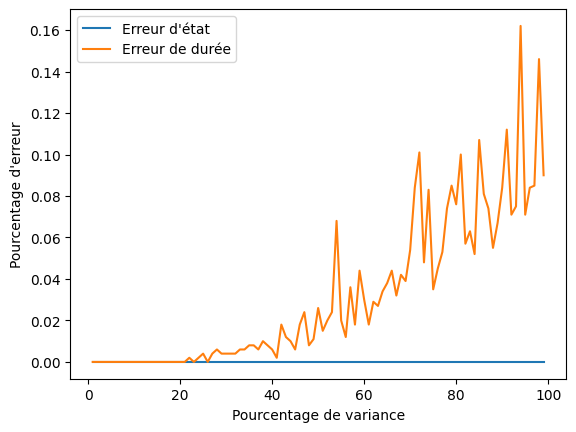

In [17]:
state_errors = []
duration_errors = []
runs = 10
steps = range(1, 100)
for step in steps:
    while True:
        try:
            states_error_avgs = []
            duration_error_avgs = []
            for _ in range(runs):
                states_error, duration_error = run_semi_hmm_gen_and_viterbi(
                    GaussObsLaw(get_state_params2(step)),
                    duration_law1
                )
                states_error_avgs.append(states_error)
                duration_error_avgs.append(duration_error)
        except ValueError:
            pass
        else:
            state_errors.append(array(states_error_avgs).mean())
            duration_errors.append(array(duration_error_avgs).mean())
            break

        
plt.plot(steps, state_errors, label="Erreur d'état")
plt.plot(steps, duration_errors, label="Erreur de durée")
plt.ylabel("Pourcentage d'erreur")
plt.xlabel("Pourcentage de variance")
plt.legend()

### Semi HMM avec des observations selon une loi discrète

Le modèle dans cette section est essentiellement identique que celui dans le cas gaussien, sauf que nous définissons une probabilité d'observation discrète : 

$$O = \{0, 1\}$$
$$B=\begin{bmatrix} 0,9 & 0,1 \\ 0,1 & 0,9 \\ \end{bmatrix} $$

In [173]:

T =  100
n = 2
mus = [0.5, 0.5]
D = 4

sem_trans_mat = array(
    [[0, 1],
    [1, 0]]
)
duration_law1 = DurationProbVec(
    array([0.1, 0.4, 0.1, 0.4]),
    [1, 2, 3, 4]
)

semi_hmm_gen = SemiGen(
    states, sem_trans_mat, discrete_obs_law, duration_law1,
)
semi_gen_res = semi_hmm_gen.gen_semi_hmm(T)

semi_vet = SemiViterbi(
    n, D, semi_gen_res, mus, duration_law1,
    discrete_obs_law.b_Sj_Ot_list, sem_trans_mat
)
semi_vet.run_viterbi()

In [165]:
ds = {v: 0 for v in duration_law1.value_vec}
for duration in semi_gen_res.duration_only:
    ds[duration] += 1

for k, v in ds.items():
    ds[k] = v / T


print("Occurrence observée de durée 1 : ", ds[1])
print("Occurrence théorique de durée 1 : ", duration_probs[1])
print("Occurrence observée de durée 2 : ", ds[2])
print("Occurrence théorique de durée 2 : ", duration_probs[2])
print("Occurrence observée de durée 3 : ", ds[3])
print("Occurrence théorique de durée 3 : ", duration_probs[3])
print("Occurrence observée de durée 4 : ", ds[4])
print("Occurrence théorique de durée 4 : ", duration_probs[4])

Occurrence observée de durée 1 :  0.11
Occurrence théorique de durée 1 :  0.1
Occurrence observée de durée 2 :  0.38
Occurrence théorique de durée 2 :  0.4
Occurrence observée de durée 3 :  0.1
Occurrence théorique de durée 3 :  0.1
Occurrence observée de durée 4 :  0.41
Occurrence théorique de durée 4 :  0.4


In [166]:
states_and_obs = list(zip(semi_gen_res.states_only, semi_gen_res.segmented_obs))
obs0 = concat([array(res[1]) for res in states_and_obs if res[0] == 0])
obs1 = concat([array(res[1]) for res in states_and_obs if res[0] == 1])

print("Observation moyenne pour état 0 : ", obs0.sum() / len(obs0))
print("Observation théorique pour état 0 : ", 0.1)
print("Observation moyenne pour état 1 : ", obs1.sum() / len(obs1))
print("Observation théorique pour état 1 : ", 0.9)

Observation moyenne pour état 0 :  0.07746478873239436
Observation théorique pour état 0 :  0.1
Observation moyenne pour état 1 :  0.8920863309352518
Observation théorique pour état 1 :  0.9


In [170]:
def get_discrete_law_error(vet_duration_only: ndarray, gen_duration_only: ndarray) -> float:
    n_ = len(gen_duration_only)
    m_ = len(vet_duration_only)
    if m_ < n_:
        gen_duration_only = gen_duration_only[:m_]
    if n_ < m_:
        vet_duration_only = vet_duration_only[:n_]

    return get_duration_error(gen_duration_only, vet_duration_only)


duration_error = get_discrete_law_error(semi_vet.durations_only, semi_gen_res.duration_only)
print("Erreur de durée", duration_error)

Erreur de durée 0.4329896907216495


In [177]:
def run_discrete() -> float:
    semi_hmm_gen = SemiGen(
        states, sem_trans_mat, discrete_obs_law, duration_law1,
    )
    semi_gen_res = semi_hmm_gen.gen_semi_hmm(T)

    semi_vet = SemiViterbi(
        n, D, semi_gen_res, mus, duration_law1,
        discrete_obs_law.b_Sj_Ot_list, sem_trans_mat
    )
    semi_vet.run_viterbi()

    return get_discrete_law_error(semi_vet.durations_only, semi_gen_res.duration_only)

def run_100_times(error_func: callable) -> float:
    return sum([error_func() for _ in range(100)]) / 100

In [178]:
run_100_times(run_discrete)

np.float64(0.48048007667304715)

## New Model

In [179]:
def duration_prob_vector(delta: int) -> DurationProbVec:
    durations = range(1, 2 * delta + 1)
    non_zero_deltas = (delta, delta * 2)
    probs = [
        0.5 if d in non_zero_deltas else 0 for d in durations
    ]
    return DurationProbVec(
        array(probs),
        durations
    )


delta_base = 2
delta = 2
D = delta * 2
n = 2

delta_duration_law = duration_prob_vector(delta)

In [180]:
semi_hmm_delta_gen = SemiGen(
    states, sem_trans_mat, discrete_obs_law, delta_duration_law,
)
semi_delta_gen_res = semi_hmm_delta_gen.gen_semi_hmm(T)

semi_delta_vet = SemiViterbi(
    n, D, semi_delta_gen_res, mus, delta_duration_law,
    discrete_obs_law.b_Sj_Ot_list, sem_trans_mat
)
semi_delta_vet.run_viterbi()

c:\Users\bensi\pyIMT\HMM Project\hmmadn\hmmadn\semihmm\semiviterbi.py:66: RuntimeWarning: divide by zero encountered in log
  + log(self.pd(d))


In [176]:
duration_error = get_discrete_law_error(
    semi_delta_vet.durations_only,
    semi_delta_gen_res.duration_only,
)

print("Erreur de durée", duration_error)

Erreur de durée 0.14


In [113]:
r = list(zip(
    semi_delta_gen_res.states_and_durations,
    semi_delta_vet.states_and_durations
))
for i in r:
    print(i)

((1, 2), (1, 2))
((0, 4), (0, 4))
((1, 2), (1, 2))
((0, 2), (0, 2))
((1, 4), (1, 4))
((0, 2), (0, 2))
((1, 4), (1, 4))
((0, 2), (0, 2))
((1, 4), (1, 4))
((0, 4), (0, 2))
((1, 2), (1, 2))
((0, 2), (0, 4))
((1, 2), (1, 2))
((0, 4), (0, 4))
((1, 4), (1, 4))
((0, 4), (0, 4))
((1, 2), (1, 2))
((0, 4), (0, 4))
((1, 4), (1, 4))
((0, 2), (0, 2))
((1, 2), (1, 4))
((0, 4), (0, 2))
((1, 2), (1, 2))
((0, 4), (0, 4))
((1, 2), (1, 2))
((0, 4), (0, 4))
((1, 2), (1, 2))
((0, 2), (0, 2))
((1, 2), (1, 2))
((0, 4), (0, 4))
((1, 2), (1, 2))
((0, 2), (0, 2))
((1, 2), (1, 2))
((0, 4), (0, 4))
((1, 2), (1, 2))
((0, 4), (0, 4))
((1, 4), (1, 4))
((0, 2), (0, 2))
((1, 2), (1, 2))
((0, 4), (0, 4))
((1, 2), (1, 2))
((0, 2), (0, 2))
((1, 2), (1, 2))
((0, 4), (0, 4))
((1, 4), (1, 4))
((0, 4), (0, 4))
((1, 4), (1, 4))
((0, 4), (0, 4))
((1, 4), (1, 4))
((0, 2), (0, 4))
((1, 4), (1, 4))
((0, 4), (0, 4))
((1, 4), (1, 2))
((0, 4), (0, 4))
((1, 2), (1, 4))
((0, 4), (0, 2))
((1, 2), (1, 2))
((0, 2), (0, 2))
((1, 2), (1, 2

In [181]:
def run_delta_viterbi(delta: int) -> float:
    delta_duration_law = duration_prob_vector(delta)
    D = delta * 2

    semi_hmm_delta_gen = SemiGen(
        states, sem_trans_mat, discrete_obs_law, delta_duration_law,
    )
    semi_delta_gen_res = semi_hmm_delta_gen.gen_semi_hmm(T)

    semi_delta_vet = SemiViterbi(
        n, D, semi_delta_gen_res, mus, delta_duration_law,
        discrete_obs_law.b_Sj_Ot_list, sem_trans_mat
    )
    semi_delta_vet.run_viterbi()

    return get_discrete_law_error(
        semi_delta_vet.durations_only,
        semi_delta_gen_res.duration_only,
    )
    

In [192]:
deltas = range(2, 20)
errors = []
for delta_ in deltas:
    errors.append(
        run_100_times(lambda: run_delta_viterbi(delta_))
    )

c:\Users\bensi\pyIMT\HMM Project\hmmadn\hmmadn\semihmm\semiviterbi.py:66: RuntimeWarning: divide by zero encountered in log
  + log(self.pd(d))


KeyboardInterrupt: 

In [194]:
errors

[np.float64(0.1928248354308921),
 np.float64(0.07721327561327558),
 np.float64(0.04158163265306124),
 np.float64(0.01478468357039786),
 np.float64(0.017550401978973413),
 np.float64(0.0041),
 np.float64(0.0052000000000000015),
 np.float64(0.0014000000000000002),
 np.float64(0.001)]